# STRF Estimation.  

**This notebooks explores STRF estimation routines using different pythom methods**




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm

# Depednecies from MNE or Theunissen Lab
import mne
import mnespikes
sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound

%matplotlib notebook
plt.ion()

The next three sections allow you to load and visualize single unit data from
The theunissen lab. Your goals are:

1. Get familiar with this data structure
2. Load your own data in a similar structure.

For the Theunissen data you can specify a directory for three brain regions and three example neurons in each.: 'mld' is the avian auditory midbrain 'ov' is the avian auditory thalamus 'l2a' is the avian auditory cortex each region has a 'good', 'avg', and 'bad' dataset, corresponding to the signal to noise ratio, quantified by information values.

In the next few cells we are reading all of the data and storing it in a pandas data frame.
The data consists of stimulus-response pairs.  Here there are 10 trials per stimulus and therefore the same stimulus is used multiple times.  We are also going to select the stimulus/response files corresponding to conspecific song. 

To use this code on your own data, you will need to write your own data load function for your data.

### Set up the path

In [3]:
# Change this if you move around files
path_base = os.path.join('../')

# For example you can specify an entire path
# path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'

data_files = glob(os.path.join(path_base, 'data', '*', '*', '*'))
# spikes = glob('../data/*/*/*')

### Read the data and store it into a pandas data frame

In [4]:
columns = ['location', 'quality', 'kind', 'number']
stims = {name: [] for name in columns}
stims['path'] = []
spikes = {name: [] for name in columns}
spikes['spike_times'] = []

# Loop through our datafiles and begin collecting information from each
for dfile in data_files:
    if 'stim' in dfile:
        prefix = 'stim'
    elif 'spike' in dfile:
        prefix = 'spike'
    else:
        # Skip because it's not a stim or spike file
        continue
    with open(dfile, 'r') as ff:
        # Pull metadata
        location_quality, kind, number = dfile.split(os.sep)[-3:]
        location, quality = location_quality.split('_')
        stimnumber = int(number.replace(prefix, ''))
        
        # If it's a stimulus file, grab the fields we want and store it with the other stim files
        if prefix == 'stim':
            dpath = ff.read().strip()
            this_columns = columns + ['path']
            iter_data = [location, quality, kind, stimnumber, dpath]
            for column, data in zip(this_columns, iter_data):
                stims[column].append(data)
        # If it's a spike file, read the spiketimes and append them to a spiketimes list
        elif prefix == 'spike':
            with open(dfile, 'r') as ff:
                spike_times = ff.readlines()
                spike_times = [ii.strip() for ii in spike_times]
                spike_times_float = []
                for trial in spike_times:
                    if len(trial) > 0:
                        this_times = np.array(trial.split(' '), dtype=float)
                    else:
                        this_times = np.array([])
                    spike_times_float.append(this_times)
            this_columns = columns + ['spike_times']
            iter_data = [location, quality, kind, stimnumber, spike_times_float]
            for column, data in zip(this_columns, iter_data):
                spikes[column].append(data)

# Wrap everything in a dataframe for some extra functionality
stims = pd.DataFrame(stims)
spikes = pd.DataFrame(spikes)
data = pd.merge(stims, spikes)

# Expand the data so that each row is a single instance
tmp_data = []
for ii, row in data.iterrows():
    for jj, trial in enumerate(row['spike_times']):
        this_data = row.copy()
        this_data['spike_times'] = trial
        this_data['repetition'] = jj
        tmp_data.append(this_data)
data = pd.DataFrame(tmp_data)
data = data.drop('number', axis=1)

# Finally convert all spike times to seconds (they are currently in milliseconds)
data['spike_times'] = data['spike_times'].apply(lambda a: [ii / 1e3 for ii in a])

In [5]:
# Displaying the panda data frame.
data

,location,quality,kind,path,spike_times,repetition
0,mld,good,flatrip,6291D00257F5DEE3D645C5E1110D089E.wav,"[0.010906, 0.012343, 0.01425, 0.027125, 0.0685...",0
0,mld,good,flatrip,6291D00257F5DEE3D645C5E1110D089E.wav,"[0.011, 0.012187, 0.093625, 0.095531, 0.153625...",1
0,mld,good,flatrip,6291D00257F5DEE3D645C5E1110D089E.wav,"[0.010437, 0.01175, 0.025937, 0.09318699999999...",2
0,mld,good,flatrip,6291D00257F5DEE3D645C5E1110D089E.wav,"[0.010531, 0.011656000000000001, 0.025968, 0.0...",3
0,mld,good,flatrip,6291D00257F5DEE3D645C5E1110D089E.wav,"[0.010968, 0.013156000000000001, 0.094156, 0.1...",4
...,...,...,...,...,...,...
419,ov,good,conspecific,A10F5407D5D86F179E9305D1453632F7.wav,"[-1.905375, -1.868875, -1.82825, -1.7599690000...",9
419,ov,good,conspecific,A10F5407D5D86F179E9305D1453632F7.wav,"[-1.988, -1.733657, -1.6650319999999998, -1.41...",10
419,ov,good,conspecific,A10F5407D5D86F179E9305D1453632F7.wav,"[-1.891, -1.70775, -1.670094, -1.6669690000000...",11
419,ov,good,conspecific,A10F5407D5D86F179E9305D1453632F7.wav,"[-1.8505, -1.747407, -1.7122819999999999, -1.6...",12


# Preprocess audio

Here we are going to calculate a spectrogram for each unique sound file.  We are going to do this using the time-frequency routines from BioSound

100%|██████████| 104/104 [00:26<00:00,  3.90it/s]


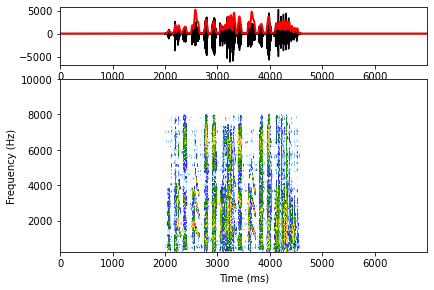

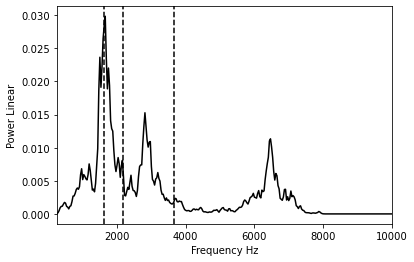

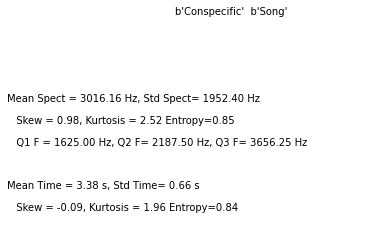

In [6]:
# Or use the theunissen lab soundsig.sound package.
all_audio_files = data['path'].unique()
tBef = -2.0   # start 2 seconds before stim
tAft = 5.0    # go 5 seconds after onset

sfreqAudio = 32000
nSilBef = int(sfreqAudio*abs(tBef))
silenceBef = np.zeros(nSilBef)
nSoundTot = int((abs(tBef)+tAft)*sfreqAudio)

# Read the audio from wave
myBioSounds = {}
for audio_file in tqdm(all_audio_files):
    sfreq_audio, audio = wavfile.read(os.path.join(path_base, 'data', 'all_stims', audio_file))
    if (sfreq_audio != sfreqAudio) :
        print('Error in audio sampling frequency')
        continue
        
    nAudio = audio.shape[0]
    nSilAft = nSoundTot - nSilBef - nAudio
    if nSilAft > 0:
        silenceAft = np.zeros(nSilAft)
        sound = np.concatenate((silenceBef, audio, silenceAft))
    elif nSilAft < 0:
        audio = audio[0:nSilAft]
        sound = np.concatenate((silenceBef, audio))
    else:
        sound = np.concatenate((silenceBef, audio))
        
    # Make a BioSound object
    myBioSound = BioSound(soundWave=sound, fs=sfreq_audio, emitter='Conspecific', calltype = 'Song')

    # Extract some acoustical features
    # Calculate amplitude enveloppe
    myBioSound.ampenv()

    # Calculate the power spectrum
    myBioSound.spectrum(f_high=10000)

    # Calcualte the spectrogram
    myBioSound.spectroCalc(spec_sample_rate=500)
    myBioSounds[audio_file] = myBioSound
    


# Plot the last one
myBioSound.plot()


In [ ]:
myBioSound.spectro.shape

# Preprocess spikes
Neuronal spiking data is essentially a collection of times, with each timepoint corresponding to one spike. Each spike file contains multiple repetitions of the same stimulus. These spikes are all from the same neuron.

To do this we'll use a small helper package called `mne-spikes`. This lets you wrangle some spiking data and quickly output it as a timeseries. It also has the ability to output data in an MNE-python class, which makes it easy to visualize and analyze.

See the following links for more information about the `Neuron` class:

* http://predictablynoisy.com/mne-spikes/
* http://predictablynoisy.com/mne-spikes/_as_gen/mnespikes.Neuron.html#mnespikes.Neuron



In [7]:
# We are going to look at the data from one neuron from l2a that has great signal to noise ratio.
this_location = 'l2a'
this_data = data.query('quality == "good" and location == @this_location and kind == "conspecific"')
spikes = this_data['spike_times'].values

# We can use this to determine how to group our events.
# "kind" corresponds to the type of sound (e.g., conspecific)
# "path" corresponds to the file path of the sound
grouping_kind = 'path'
event_types = this_data[grouping_kind].values

# Store the spiking data in the Neuron class.
neuron = mnespikes.Neuron(spikes, sfreq=500.0, events=event_types,
                          tmin=tBef, tmax=tAft, name='neuron_{}'.format(this_location))

neuron

Name: neuron_l2a | Num Events: 200 | Events: ['07E250DFF0DEF4C41369A5506E2A1C85.wav', '0CE3F97518B992FDCA431CEB28645617.wav', '17456A9C4456E9FEE94F53E6FE605317.wav', '40099BFD657ADBB4BDE2AA209A2FD8E6.wav', '550D5E9B6A6729293ED6661E41263EDC.wav', '5AD1CD7EF60CEFD186531C25C2EA92FA.wav', '9315FDE0647E83B7B039756FCFE361DE.wav', '98201FB5EC3043C63227ADB085724600.wav', '9B6E45B0D09E578545E4DFED84F5DC04.wav', '9C70ED65D65F5C49A4CA8F2264FAAB8D.wav', 'A10F5407D5D86F179E9305D1453632F7.wav', 'B775C95A9E64A42DF1C9D1ED84950E31.wav', 'C6454841DE27D1D8D3A22C5275EC8213.wav', 'CB3F8C1BDBEB75DAFF8D61406CC11E6C.wav', 'D54ABC42488F995C789F351A34316039.wav', 'D6E2826E7D682FFFD6DBB8E80B87DB22.wav', 'D770FEF9E30C6EF464897E94F103BD0C.wav', 'DEB5A1D698864531775798C877E677C7.wav', 'E8B242D5888D89E139C2B1C0A127A3B6.wav', 'F9698B0C2CA2A2BDF417E8F4891EE5F0.wav'] | tmin/tmax: (-2.0, 5.0)

In [8]:
epochs = neuron.to_mne()
# The 200 events correspond to 10 trials to 20 different song (conspecific).

200 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


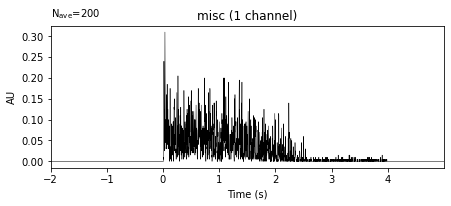

In [9]:
# As this is an MNE object, we can use MNE functions to do visualization.
# The `average` method averages across all trials.
av = epochs.average([0])
av.plot();

Next we'll select all of the trials that correspond to a single filename. Remember we'll have 10 repetitions per filename.

In [10]:
# Print a list of the file names in this MNE object
print(epochs.event_id.keys())

dict_keys(['07E250DFF0DEF4C41369A5506E2A1C85.wav', '0CE3F97518B992FDCA431CEB28645617.wav', '17456A9C4456E9FEE94F53E6FE605317.wav', '40099BFD657ADBB4BDE2AA209A2FD8E6.wav', '550D5E9B6A6729293ED6661E41263EDC.wav', '5AD1CD7EF60CEFD186531C25C2EA92FA.wav', '9315FDE0647E83B7B039756FCFE361DE.wav', '98201FB5EC3043C63227ADB085724600.wav', '9B6E45B0D09E578545E4DFED84F5DC04.wav', '9C70ED65D65F5C49A4CA8F2264FAAB8D.wav', 'A10F5407D5D86F179E9305D1453632F7.wav', 'B775C95A9E64A42DF1C9D1ED84950E31.wav', 'C6454841DE27D1D8D3A22C5275EC8213.wav', 'CB3F8C1BDBEB75DAFF8D61406CC11E6C.wav', 'D54ABC42488F995C789F351A34316039.wav', 'D6E2826E7D682FFFD6DBB8E80B87DB22.wav', 'D770FEF9E30C6EF464897E94F103BD0C.wav', 'DEB5A1D698864531775798C877E677C7.wav', 'E8B242D5888D89E139C2B1C0A127A3B6.wav', 'F9698B0C2CA2A2BDF417E8F4891EE5F0.wav'])


In [12]:
# Select trials of a particular condition type and clip to a maximum of 3 seconds
filename = '07E250DFF0DEF4C41369A5506E2A1C85.wav'
tmin = tBef
tmax = tAft
epochs_con = epochs[filename].crop(tmin, tmax)

10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


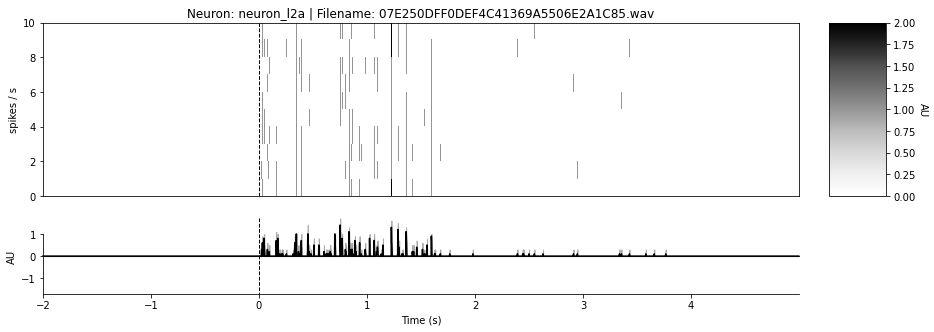

In [13]:
# Make a raster plot of the epochs along with the average response below.
### NOTE: If it seems like there are no spikes being plotted, try decreasing the sampling
### frequency of the Neuron when constructing it above. If there are too mnay timepoints, then the
### spike visualizations can get hidden by all of the whitespace.
picks = [0]  # This tells MNE which channel to plot...in this case, we have only one channel
fig = epochs_con.plot_image(picks, show=False, vmin=0, cmap='Greys')
fig[0].set_size_inches(15, 5)
fig[0].axes[0].set(ylabel='spikes / s', ylim=[0, None],
                   title='Neuron: {} | Filename: {}'.format(neuron.name, filename));

In [14]:
# Trying a STRF estimation

from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

In [15]:
nf, nt = myBioSound.spectro.shape

In [75]:
# Prepare model data
stims = list(epochs.event_id.keys())
nstims = len(stims)
nfUsed = 150
X = np.zeros((nt*nstims, nfUsed))
Y = np.zeros(nt*nstims)

for istim, stimName in enumerate(stims):
    X[istim*nt:(istim+1)*(nt),:] = myBioSounds[stimName].spectro.transpose()[:,0:nfUsed]
    Y[istim*nt:(istim+1)*(nt)] = epochs[stimName]._data.squeeze().mean(0)
  
XAmp[:,0] = 20*np.log10(np.power(10,X/20).sum(1))
    
# Fix X to have a max dB range and 0 mean
DBNOISE = 50
maxB = X.max()
minB = maxB-DBNOISE
X[X < minB] = minB
X = X - X.mean(0)

maxB = XAmp.max()
minB = maxB-DBNOISE
XAmp[XAmp < minB] = minB
XAmp = XAmp - XAmp.mean()

# Fix Y to have zero mean
Y = Y - Y.mean()


In [76]:
X.mean(0).shape

(150,)

<IPython.core.display.Javascript object>


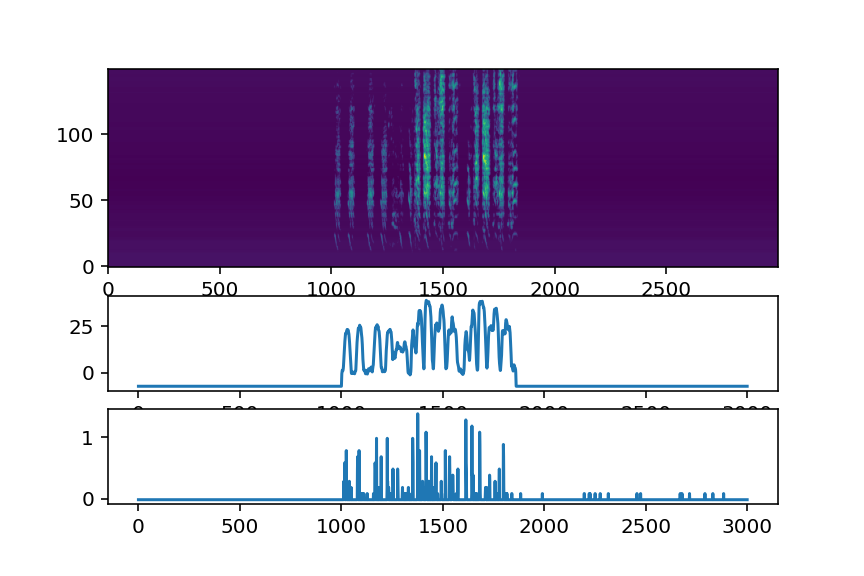

In [124]:
# Plot the spectrogram and response
plt.figure()
plt.subplot(2,1,1)
plt.imshow(X[0:3000,:].transpose(), aspect='auto', origin='lower')
plt.subplot(4,1,3)
plt.plot(XAmp[0:3000])
plt.subplot(4,1,4)
plt.plot(Y[0:3000])

<IPython.core.display.Javascript object>


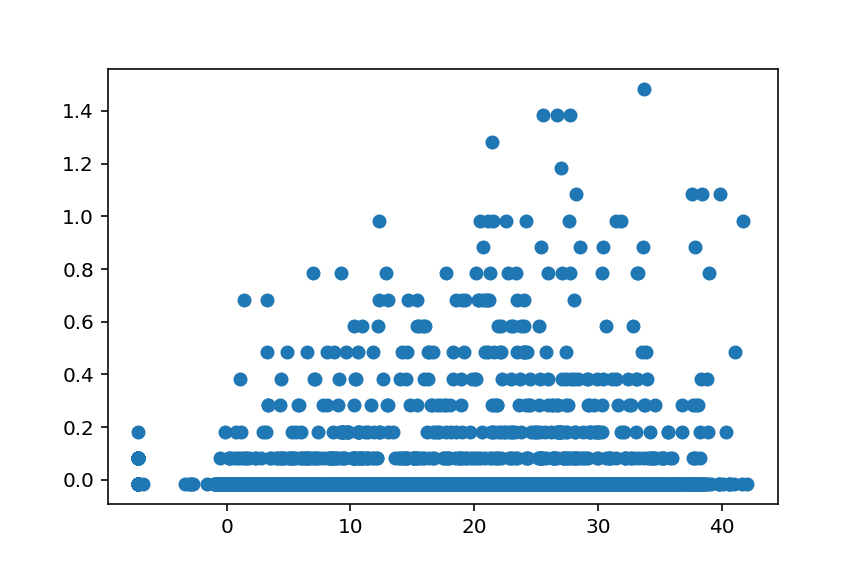

In [125]:
plt.figure()
plt.scatter(XAmp[0:10000], Y[0:10000])

In [127]:
# Initialize the model
# Define the delays that we will use in the receptive field
tmin, tmax = -.05, .05
sfreq = 500.0


rf = ReceptiveField(tmin, tmax, sfreq, estimator=1000, scoring='r2', edge_correction=True, fit_intercept=True)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 1 delay since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 1

n_splits = nstims
cv = KFold(n_splits)
n_channels = 1


# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, 1, n_delays))
scores = np.zeros(n_splits)
for ii, (train, test) in enumerate(cv.split(XAmp)):
    print('split %s / %s' % (ii + 1, n_splits))
    rf.fit(XAmp[train], Y[train])
    scores[ii] = rf.score(XAmp[test], Y[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 output
    coefs[ii,:,:] = rf.coef_
times = rf.delays_ / float(rf.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_scores = scores.mean(axis=0)

split 1 / 20
Fitting 1 epochs, 1 channels



split 2 / 20
Fitting 1 epochs, 1 channels



split 3 / 20
Fitting 1 epochs, 1 channels



split 4 / 20
Fitting 1 epochs, 1 channels



split 5 / 20
Fitting 1 epochs, 1 channels



split 6 / 20
Fitting 1 epochs, 1 channels



split 7 / 20
Fitting 1 epochs, 1 channels



split 8 / 20
Fitting 1 epochs, 1 channels



split 9 / 20
Fitting 1 epochs, 1 channels



split 10 / 20
Fitting 1 epochs, 1 channels



split 11 / 20
Fitting 1 epochs, 1 channels



split 12 / 20
Fitting 1 epochs, 1 channels



split 13 / 20
Fitting 1 epochs, 1 channels



split 14 / 20
Fitting 1 epochs, 1 channels



split 15 / 20
Fitting 1 epochs, 1 channels



split 16 / 20
Fitting 1 epochs, 1 channels



split 17 / 20
Fitting 1 epochs, 1 channels



split 18 / 20
Fitting 1 epochs, 1 channels



split 19 / 20
Fitting 1 epochs, 1 channels



split 20 / 20
Fitting 1 epochs, 1 channels


In [128]:
scores

array([0.24737208, 0.2776376 , 0.23513416, 0.26314903, 0.30731748,
       0.23304454, 0.29166028, 0.2717117 , 0.29481184, 0.25207413,
       0.15046796, 0.26053404, 0.25904909, 0.14491125, 0.217566  ,
       0.19111653, 0.31586019, 0.17106727, 0.32158639, 0.21246589])

<IPython.core.display.Javascript object>


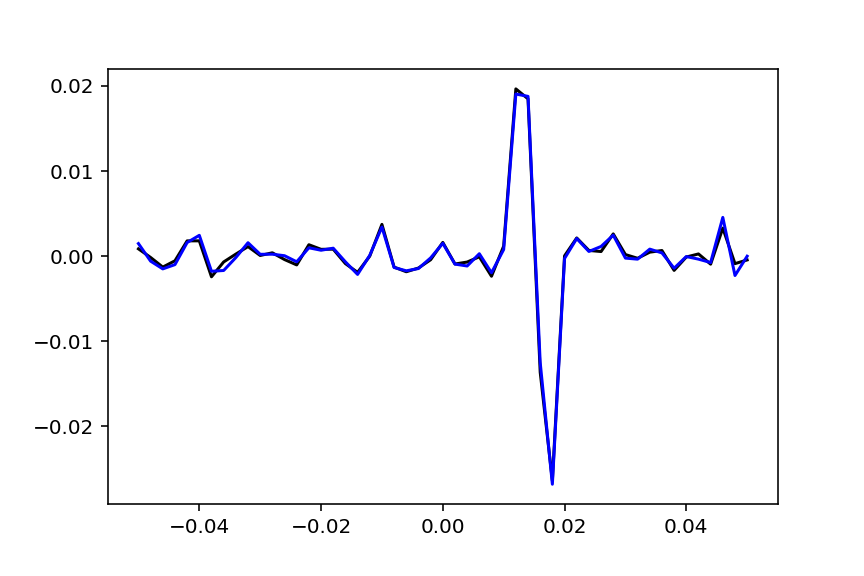

In [129]:
plt.figure()
plt.plot(times, coefs[0,0,:],'k')
plt.plot(times, coefs[1,0,:],'b')

Fitting 1 epochs, 1 channels


<IPython.core.display.Javascript object>


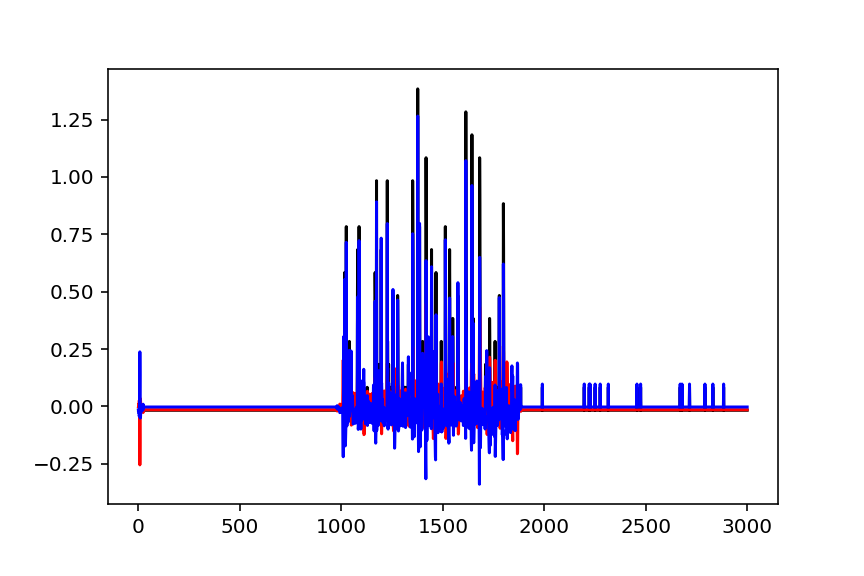

In [130]:
# Because we are happy with the results we are going to make a single model to get residuals
rf.fit(XAmp, Y)
Ypre = rf.predict(XAmp)
Yres = Y-Ypre

plt.figure()
plt.plot(Y[0:3000],'k')
plt.plot(Ypre[0:3000], 'r')
plt.plot(Yres[0:3000], 'b')



In [105]:
# Now fitting a full STRF model

strf = ReceptiveField(tmin, tmax, sfreq, estimator=1000, scoring='r2', edge_correction=True, fit_intercept=True)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 1 delay since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 1

n_splits = nstims
cv = KFold(n_splits)


# Iterate through splits, fit the model, and predict/test on held-out data
strfCoefs = np.zeros((n_splits, nfUsed, n_delays))
strfR2s = np.zeros(n_splits)
for ii, (train, test) in enumerate(cv.split(X)):
    print('split %s / %s' % (ii + 1, n_splits))
    strf.fit(X[train], Yres[train])
    strfR2s[ii] = strf.score(X[test], Yres[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 output
    strfCoefs[ii,:,:] = strf.coef_
times = strf.delays_ / float(strf.sfreq)

# Average scores and coefficients across CV splits
strfCoef = strfCoefs.mean(axis=0)
strfR2 = strfR2s.mean(axis=0)

split 1 / 20
Fitting 1 epochs, 150 channels



split 2 / 20
Fitting 1 epochs, 150 channels



split 3 / 20
Fitting 1 epochs, 150 channels



split 4 / 20
Fitting 1 epochs, 150 channels



split 5 / 20
Fitting 1 epochs, 150 channels



split 6 / 20
Fitting 1 epochs, 150 channels



split 7 / 20
Fitting 1 epochs, 150 channels



split 8 / 20
Fitting 1 epochs, 150 channels



split 9 / 20
Fitting 1 epochs, 150 channels



split 10 / 20
Fitting 1 epochs, 150 channels



split 11 / 20
Fitting 1 epochs, 150 channels



split 12 / 20
Fitting 1 epochs, 150 channels



split 13 / 20
Fitting 1 epochs, 150 channels



split 14 / 20
Fitting 1 epochs, 150 channels



split 15 / 20
Fitting 1 epochs, 150 channels



split 16 / 20
Fitting 1 epochs, 150 channels



split 17 / 20
Fitting 1 epochs, 150 channels



split 18 / 20
Fitting 1 epochs, 150 channels



split 19 / 20
Fitting 1 epochs, 150 channels



split 20 / 20
Fitting 1 epochs, 150 channels


In [106]:
strfR2s

array([-0.5251857 , -0.59533292, -0.87119852, -1.08480423, -0.70408543,
       -0.78177483, -0.81367159, -0.88373332, -0.58049288, -0.92469081,
       -0.95258296, -1.72539606, -0.34895129, -1.25705891,  0.26804594,
       -0.60439675, -0.7156069 ,  0.25962479, -0.77913065, -0.79077416])

<IPython.core.display.Javascript object>


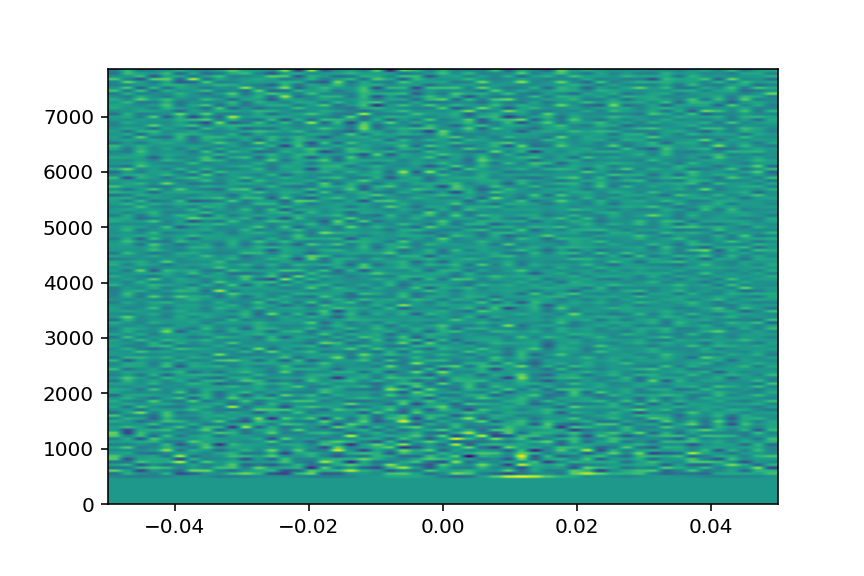

<IPython.core.display.Javascript object>


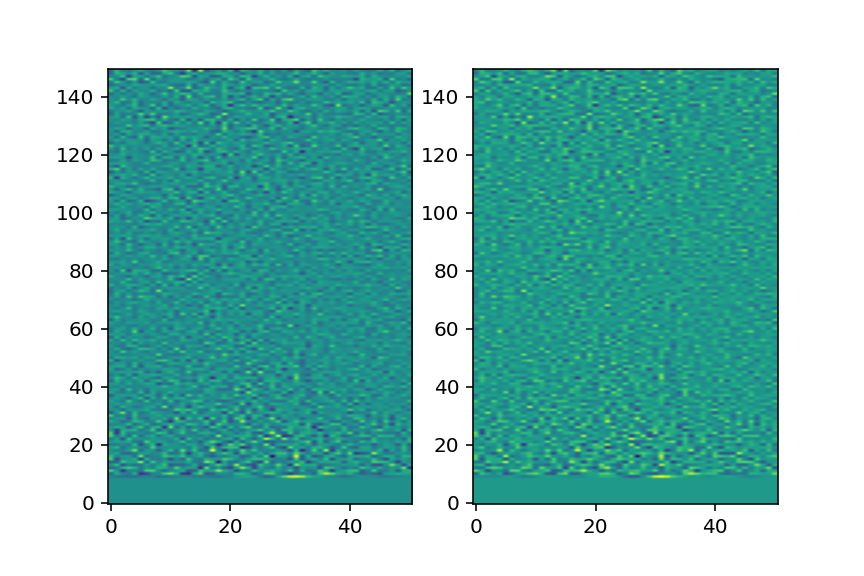

In [107]:
plt.figure()
plt.imshow(strfCoef, aspect='auto', origin='lower', extent=[times[0], times[-1], myBioSound.fo[0], myBioSound.fo[nfUsed]])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(strfCoefs[0,:,:], aspect='auto', origin='lower')
plt.subplot(1,2,2)
plt.imshow(strfCoefs[1,:,:], aspect='auto', origin='lower')

nme code works well and takes advantage of time delay but:
1. Not efficient for cross-validation as it recalculates the correlations each time
2. Not efficient for multiple values of lambda.
3. R2 cross-validated appears wrong.


In [131]:
# Because we are happy with the results we are going to make a single model to get residuals
strf.fit(X, Yres)
Ypre2 = strf.predict(X)
Yres2 = Y-Ypre-Ypre2




Fitting 1 epochs, 150 channels


<IPython.core.display.Javascript object>


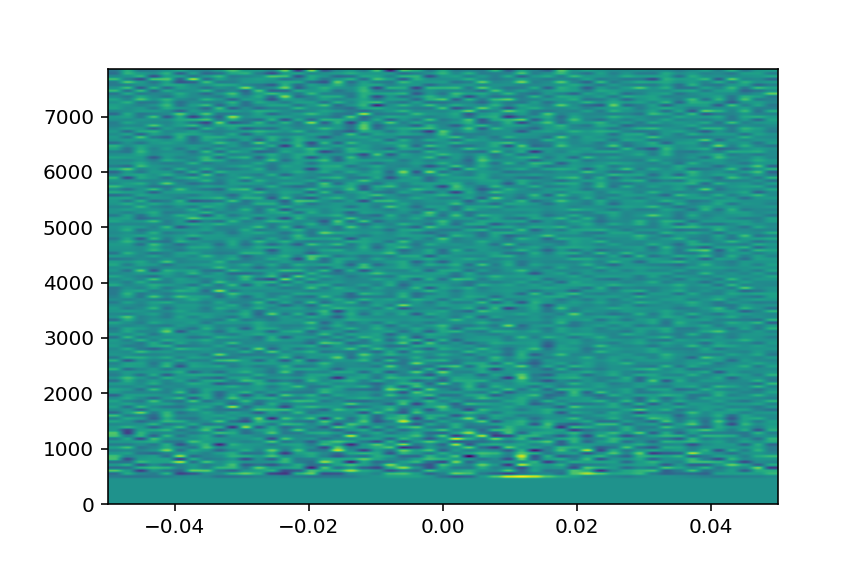

In [132]:
plt.figure()
plt.imshow(strf.coef_, aspect='auto', origin='lower', extent=[times[0], times[-1], myBioSound.fo[0], myBioSound.fo[nfUsed]])
plt.show()


<IPython.core.display.Javascript object>


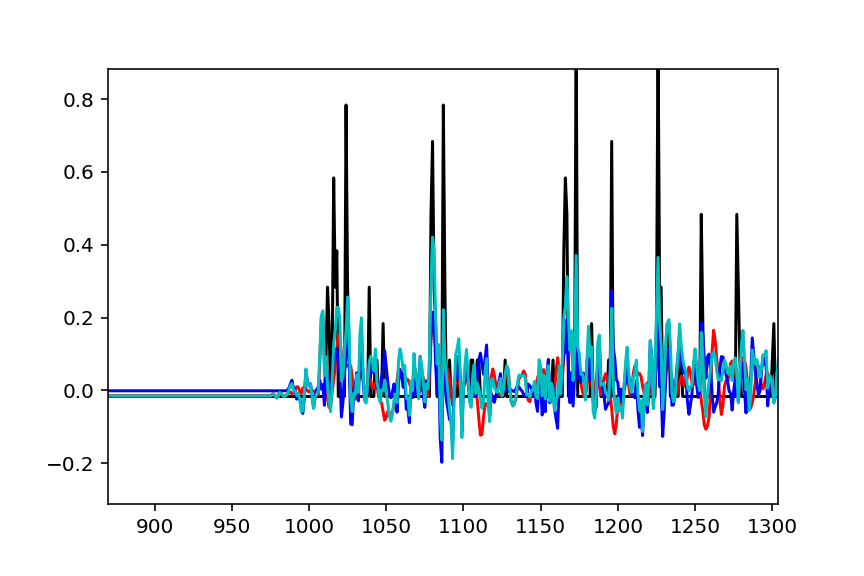

In [118]:

plt.figure()
plt.plot(Y[0:3000],'k')
plt.plot(Ypre[0:3000], 'r')
plt.plot(Ypre2[0:3000], 'b')
plt.plot(Ypre[0:3000]+Ypre2[0:3000], 'c')
plt.show()

In [122]:
Ypre3 = Ypre + Ypre2
Ypre3[Ypre3<Y.min()] = Y.min()


R2 = 1 - np.var(Y-Ypre3)/np.var(Y)


In [123]:
R2

0.6506875555475644

<IPython.core.display.Javascript object>


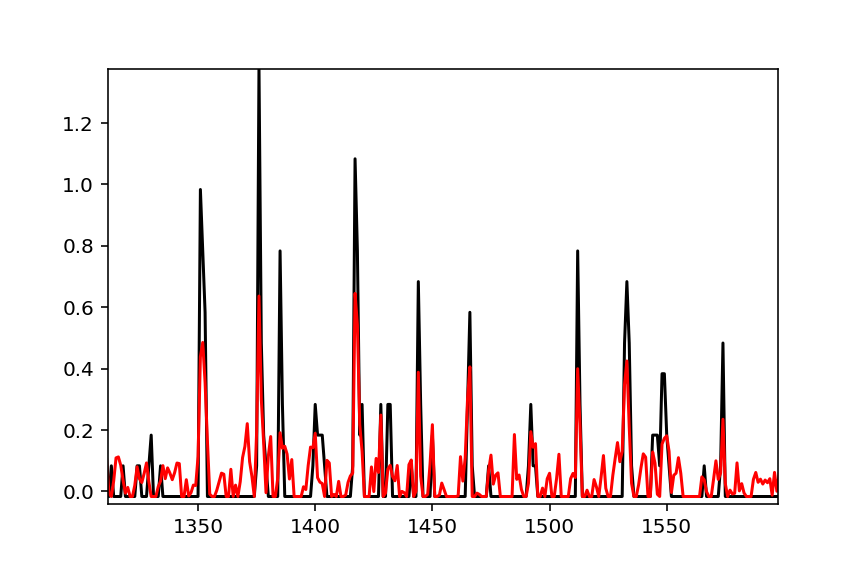

In [121]:
plt.figure()
plt.plot(Y[0:3000],'k')
plt.plot(Ypre3[0:3000], 'r')

plt.show()